# **Chances of surviving the Titanic!**
Hey, so I finally decided to start with kaggle and what a better way to do so than the famous Titanic dataset so here we go.

---------------
## Ultimate goal of the analysis
- Build a machine learning model to classify who survived or not.

## Bonus Quests on the way
+ Did women and children have priority? (**Yes**)
+ What were the chances of families surviving? (**Yes, 3 members to be specific**)
+ Did the rich have higher chance of surviving? (**Yes**)

---------------

## Conclusion
1. Started with simple Descriptive Analysis to check the data shape, statistics, null values and correlations.
2. Did some data cleaning and EDA including checking distributions, outliers and how each feature affect survival chance.
3. Feature Engineered 2 new features.
4. Preprocessed the data by doing Normalization then splitting it into train/test sets and finally encoded the categorical features.
5. Started modeling with light baseline evaluation of each model then tuned them one by one and finally implemented an Ensemble model of the tuned ones achieving **83.51% accuracy**.
![Ensamble Model](https://i.imgur.com/tnECU0j.jpeg "final_model")

-----------
### Files:
* 'train.csv': labeled data
* 'test.csv': prediction target
---------------

### Data:
| Feature | Description | DType | Variable Type | Comments |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| `Survived` | Passenger survived or not | int64 | Categorical | 0 = No, 1 = Yes |
| `Pclass` | Ticket class | int64 | Categorical | 1 = 1st, 2 = 2nd, 3 = 3rd |
| `Embarked` | Port of Embarkation | object | Categorical | C = Cherbourg, Q = Queenstown, S = Southampton |
| `Sex` | Male, Female | object | Categorical | - |
| `Age` | Age in years | float64 | Numerical | - |
| `SibSp` | # of siblings / spouses aboard the Titanic | int64 | Numerical | - |
| `Parch` | # of parents / spouses aboard the Titanic | int64 | Numerical | - |
| `Fare` | Passenger fare | float64 | Numerical | - |
| `Cabin` | Cabin code | object | Combined | - |
| `Ticket` | Ticket code | object | Combined | - |

### Engineered Features:
| Feature | Description | DType | Variable Type | Comments |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| `Prefix` | Title extracted from `Name` col mapped into 4 categories | object | Categorical | Mr, Mrs, Master, Noble/Dr/Religion/Military |
| `FamilySize` | `Parch` + `SibSp` and mapped into 4 categories | object | Categorical | Alone, Small, Medium, Big |

----------------

# Table of Content

1. [Descriptive Analysis](#da)
   - 1.1. [Shape of the data](#shape)
   - 1.2. [Summary Statistics](#stat)
   - 1.3. [Null Values](#null)
   - 1.4. [Correlation Matrix](#corr)
   
   
2. [Exploratory Data Analysis](#eda)
   - 2.1. [Data Cleaning](#clean)
      + 2.1.1. [Missing Data](#miss)
         - 2.1.1.1. [`Fare` missing value](#fare)
         - 2.1.1.2. [`Age` missing value](#age)
         - 3.1.1.3. [`Embarked` missing value](#embarked)
      + 2.1.2. [Dropping Data](#drop)
   - 2.2. [Distribution plots](#dist)
   - 2.3. [Survival Rates](#rates)
   - 2.4. [Outliers](#outliers)
      + 2.4.1. [Box plots](#box)
      + 2.4.2. [Interquartile Range to detect outliers](#iqr)
      + 2.4.3. [Manual Checking](#manual)
      
      
3. [Feature Engineering](#eng)
   - 3.1. [`Prefix` feature from `Name` col](#prefix)
   - 3.2. [`FamilySize` feature from `SibSp` & `Parch` Features](#family)
   - 3.3. [`Pclass` feature](#pclass)


4. [Preprocessing](#pre)
   - 4.1. [Normalizing](#normal)
   - 4.2. [Spliting](#split)
   - 4.3. [Transforming](#transform)


5. [Modeling](#model)
   - 5.1. [Model Baseline Evaluation](#baseline)
   - 5.2. [Model Tuning](#tuning)
   - 5.3. [Ensemble Modeling](#voting)
-----------------------------

### 0.1 Importing libraries and setup

In [51]:
# Analytics and manipulating modules
import pandas as pd
import numpy as np

# Visualization modules
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Others
import itertools
from collections import Counter
import warnings

# Notebook settings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
sns.set_palette(sns.mpl_palette("brg"))

# Model preprocessing, pipeline and evaluation modules
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

### 0.2 Load in the data

In [2]:
# loading the data
train_df_raw = pd.read_csv('datasets/train.csv')
eval_df_raw = pd.read_csv('datasets/test.csv')

# save the id col for later
eval_df_ids = eval_df_raw['PassengerId']

----------------
## 1. Descriptive Analysis <a name='da'></a>
In this section we will go through some basic data inspection:
1. Shape of the data
2. Summary statistics
3. Null data inspection
4. Correlation Matrix

### Summary
- Data shape:
  1. `Name` feature could be useful later if we extract the Prefixes (titles).
  2. `PassengerId` feature wont be of any use.
  3. `Ticket` and `Cabin` features contain numbers prefixed by characters.


- Summary statistics:
  1. We might have to deal with some missing values later by looking at `Age` feature.
  2. We dont have negative values in any col.
  3. `Fare` feature has a huge discrepancy between 75% quartile and max values indicating skewness and potential outliers.


- Null values:
  1. We have alot of missing data.
  2. We will have to impute most of the missing data since the dataset isn't that big.


- Correlation Matrix
  1. Decent positive correlation between `SibSp` and `Parch`, potentially indicates they could be feature engineered into 1 feature.
  2. Decent negative correlation between `Fare` and `Pclass`, makes sense the richer the better the class and potentially the older the age too which is why `Age` is also related.
  3. Decent negative correlation between `Suvived` and `Pclass` and decent positive correlation between `Survived` and `Fare` potentially indicates the rich had more survival chance.


### 1.1. Shape of the data  <a name='shape'></a>

In [3]:
# Shapes and columns
print('Training DF: ', train_df_raw.shape, '\nEvaluation DF: ', eval_df_raw.shape)

# Checking out the data
display(train_df_raw.head())
display(eval_df_raw.head())

Training DF:  (891, 12) 
Evaluation DF:  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 1.2. Summary Statistics <a name='stat'></a>

In [4]:
# Summary statistics
display(train_df_raw.describe())
display(eval_df_raw.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### 1.3. Null Values <a name='null'></a>

In [5]:
# Null values and datatypes check
train_df_raw.info()
eval_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [6]:
# creating a table with missing values counts and percentages as a function for reusability
def create_nulls_table(df):
    '''
    create_nulls_table():
        This function creates a dataframe as a table of missing (null) values where
        the rows of the table are the columns of the missing values and the columns
        are the counts of and the percentage of the missing values.

    Args:
        df (pd.DataFrame): Dataframe.
        
    Returns:
        pd.DataFrame: nulls_table
            {
                'Counts': missing values,
                'Percentages': missing values percentages
            }
    '''
    missing_values = df.isna().sum() # getting absolute count of null values
    missing_counts = missing_values[missing_values > 0] # filtering out the columns with no nulls
    missing_perc = (missing_values/len(df))*100 # calculate the percentage of the null values relative to the DF
    # concat absolute counts and percentages to formulate the table
    nulls_table = pd.concat([missing_counts, missing_perc[missing_perc > 0]], axis=1,\
                            keys=['Counts', 'Percentages']).round(2)
    return nulls_table

# creating nulls table for both DFs
train_df_nulls = create_nulls_table(train_df_raw)
display(train_df_nulls)
eval_df_nulls = create_nulls_table(eval_df_raw)
display(eval_df_nulls)

,Counts,Percentages
Age,177,19.87
Cabin,687,77.10
Embarked,2,0.22


,Counts,Percentages
Age,86,20.57
Fare,1,0.24
Cabin,327,78.23


### 1.4. Correlation Matrix <a name='corr'></a>

<AxesSubplot:>

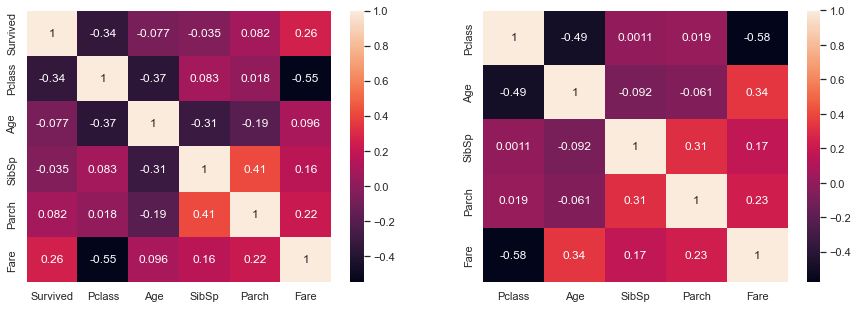

In [7]:
# Create a correlation matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(train_df_raw.drop(['PassengerId'], axis=1).corr(), annot=True, ax=ax[0])
sns.heatmap(eval_df_raw.drop(['PassengerId'], axis=1).corr(), annot=True, ax=ax[1])

---------------
## 2. Exploratory Data Analysis <a name='eda'></a>
After inspecting the data we found some problems we will deal with them then look at some of our data distributions and features affect each other, the EDA process will go through these steps:
1. Data Cleaning
2. Distribution plots
3. Survival Rates
4. Checking for Outliers


### Summary

- **Data Cleaning**
  1. Checked some distributions of the features with missing values.
  2. Decided to impute `Fare`,`Age` and `Embarked`.
  3. Decided to drop `Cabin`,`Ticket` and `PassengerId`.
  4. Extracted the `Prefix` out of the `Name` feature.
     + `Fare` > imputed using median of `Fare` feature of the same `Pclass`.
     + `Age` > imputed using the median of `Age` of the same `Prefix`, `Pclass`, `Parch` and `SibSp` if existed otherwise the median of the `Age` feature.
     + `Embarked` > imputed using the most frequent value (Mode imputing).


- **Distribution plots**
  1. Created 2 distribution plots for each feature:
     + Feature distribution plot.
     + Feature distribution by survival rates.

  2. `Fare`, `Parch` and `SibSp` are skewed and will need some preprocessing


- **Survival Rates**
  + Created heatmaps for each feature by survival counts showing how each feature affected the chances of surviving.


- **Checking for Outliers**
  1. Created boxplots and noticed how some features had extreme outliers (`Age`, `Fare`).
  2. Implemented IQR method to filter out outliers.
  3. Manually checked outliers to check if any of them shouldnt be dropped.
  4. dropped the outliers.

### 2.1. Data Cleaning <a name='clean'></a>
#### 2.1.1. Missing Data <a name='miss'></a>
- For variables with less than 5% missing data we could opt into removing the records hence its not worth the time and effort to impute them (`Embarked` in training DF and `Fare` in evaluation DF) but thats not optimal specially since the dataset isn't that big so we won't.
- What we will do instead is we will impute missing data and since we got the feeling that `Age` column is skewed abit we will using the median imputation.

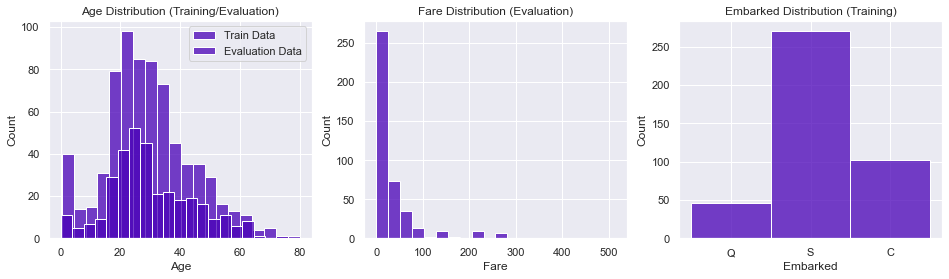

In [8]:
fig, ax = plt.subplots(1,3, figsize=(16,4))

# plotting the Age column distribution
sns.histplot(data=train_df_raw, x='Age', bins=20, label='Train Data', ax=ax[0])
sns.histplot(data=eval_df_raw, x='Age', bins=20, label='Evaluation Data', ax=ax[0])
ax[0].set_title('Age Distribution (Training/Evaluation)')
ax[0].legend()

# plotting the Fare column distribution
sns.histplot(data=eval_df_raw, x='Fare', bins=20, ax=ax[1])
ax[1].set_title('Fare Distribution (Evaluation)')

# plotting the Embarked column distribution
sns.histplot(data=eval_df_raw, x='Embarked', bins=20, ax=ax[2])
ax[2].set_title('Embarked Distribution (Training)')

plt.show()

- Our intuition was correct based on the plot, Hence we will use Median Imputation for `Age` and `Fare` cols however `Embarked` col is categorical so we will opt into Mode Imputation for that.
- But before Imputing the data it makes sense to group both the training dataset and the evaluation dataset so the filling value isnt biased and may result in overfitting to the training set.
- Also we will copy the dataframes before we start modifying them.

In [9]:
# Copying the dataframes
train_df = train_df_raw
eval_df = eval_df_raw

#creating a type column so we can split the data again later
train_df['df_type'] = 'train_df' 
eval_df['df_type'] = 'eval_df'

# grouping the dataframes
combined_df = pd.concat([train_df, eval_df], axis=0).reset_index(drop=True)
combined_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,df_type
1216,1217,NaN,3,"Assam, Mr. Ali",male,23.0,0,0,SOTON/O.Q. 3101309,7.0500,NaN,S,eval_df
890,891,0.0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q,train_df
716,717,1.0,1,"Endres, Miss. Caroline Louise",female,38.0,0,0,PC 17757,227.5250,C45,C,train_df
239,240,0.0,2,"Hunt, Mr. George Henry",male,33.0,0,0,SCO/W 1585,12.2750,NaN,S,train_df
674,675,0.0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S,train_df
444,445,1.0,3,"Johannesen-Bratthammer, Mr. Bernt",male,NaN,0,0,65306,8.1125,NaN,S,train_df
597,598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S,train_df
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,train_df
298,299,1.0,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,30.5000,C106,S,train_df
476,477,0.0,2,"Renouf, Mr. Peter Henry",male,34.0,1,0,31027,21.0000,NaN,S,train_df


##### 2.1.1.1. `Fare` missing value <a name='fare'></a>
Thinking about imputing the `Fare` value we need to inspect the properties of the passenger with the missing value since we dont want to potentially create an outlier specially since we know his `Pclass` exist which is heavily related to `Fare` hence we would use the median of his `Pclass` for the `Fare` imputing.

In [10]:
combined_df[combined_df.Fare.isna()] # checking the passenger with missing Fare
# imputing the Fare using the median of his Pclass
combined_df.Fare.fillna(combined_df[combined_df.Pclass == 3].Fare.median(), inplace=True)

##### 2.1.1.2. `Age` missing values <a name='age'></a>
- Now this one is challenging we could always use median of the age to fill missing values but that won't be optimal so we will try to understand more information about the passengers with missing `Age` values so we could impute more accurate value.
- We're going to use a similar technique to what we did with the `Fare` feature ealier however for imputing `Age` we will use name `Prefix` since its strongly related to a person's `Age` as well as `Pclass`, `Parch` and `SibSp` since they're correlated (-ve correlation) as we saw in the heatmap earlier.

In [11]:
# get the indices of the passengers with missing Age values
missing_age_indices = combined_df[combined_df.Age.isna()].index 
# spoiler alert we were going to use this technique later to feature engineer the name feature into a useful one
# extract the title from the name since its highly related to age
combined_df['Prefix'] = combined_df.Name.apply(lambda x:x.split(', ')[1].split('.')[0]).str.strip()
# looping over missing value's indices
for index in missing_age_indices: 
    # for missing values try to find median of a passenger of the same criteria 
    combined_df.Age.iloc[index] = \
    combined_df.Age[((combined_df.Prefix == combined_df.iloc[index].Prefix) & \
                    (combined_df.Pclass == combined_df.iloc[index].Pclass) & \
                    (combined_df.Parch == combined_df.iloc[index].Parch) & \
                    (combined_df.SibSp == combined_df.iloc[index].SibSp))].median()
    if (pd.isna(combined_df.Age.iloc[index])): # if no passenger with the same criteria found
        combined_df.Age.iloc[index] = combined_df.Age.median()

##### 2.1.1.3. `Embarked` missing values <a name='embarked'></a>
This one is straight forward we will impute the missing values with the most frequent value (Mode Imputing).

In [12]:
# Mode imputing 1st value (Most frequent) on Embarked col
combined_df.Embarked.fillna(combined_df.Embarked.mode()[0], inplace=True)

#### 2.1.2. Dropping Data <a name='drop'></a>
- `Cabin` column since it has so many missing data and some passengers own more than 1 cabin too.
- `PassengerId` totally random numbers doesnt logically affect the surviving chance.
- `Ticket` Same thing.

In [13]:
# drop cabin, id, ticket cols
combined_df.drop(['Cabin', 'PassengerId', 'Ticket'], axis=1, inplace=True)

# checking our cleaning results
combined_df_nulls = create_nulls_table(combined_df)
display(combined_df_nulls)

,Counts,Percentages
Survived,418,31.93


Great, All the nulls have been taken care of and we only have the unlabeled data left
### 2.2. Distribution plots <a name='dist'></a>
Distribution plots can help us extract valuable info about each feature also determine if we will need to normalize it later or not before training the model.

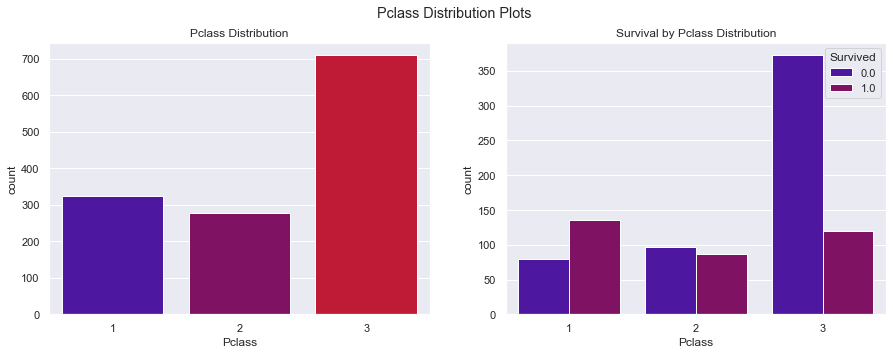

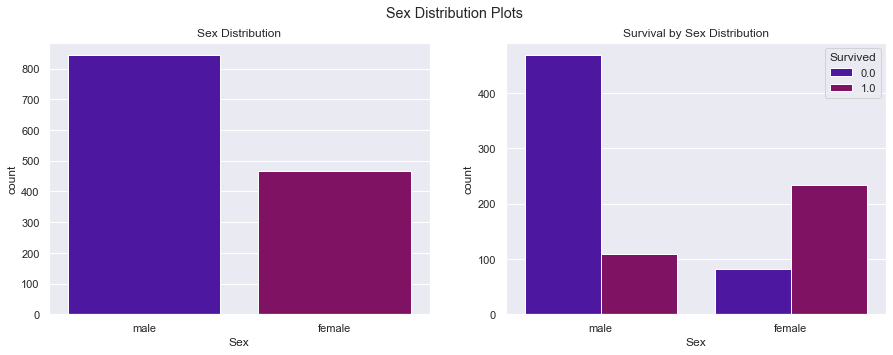

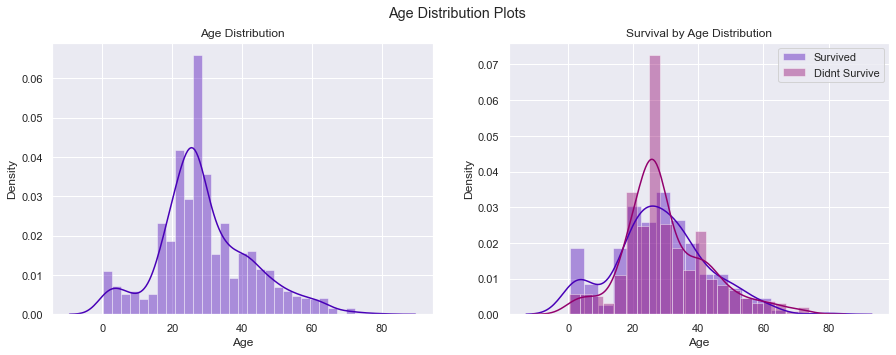

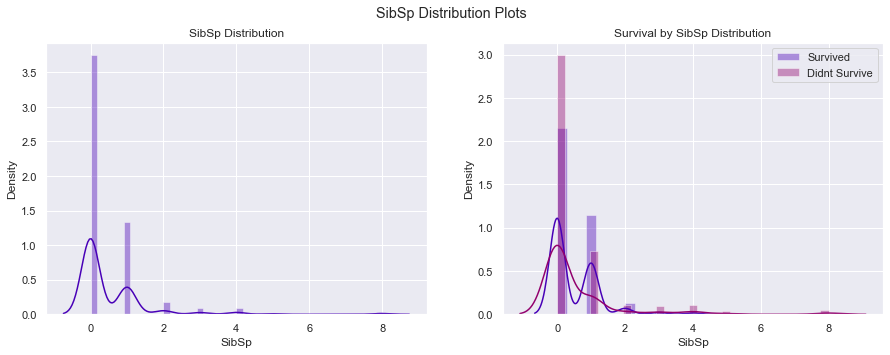

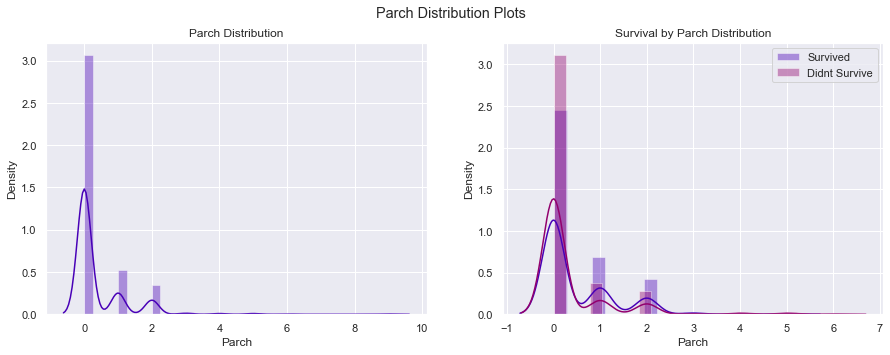

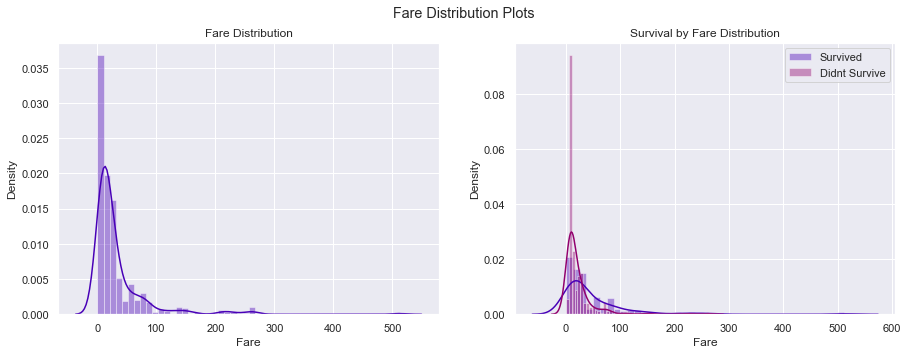

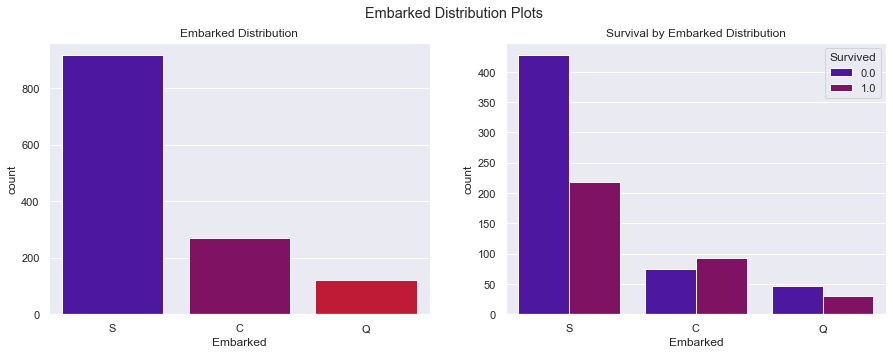

In [14]:
# defining a function to plot 2 distplots for the feature and for the suvival by the feature
def feature_dist_plots(feature, numerical=True):
    '''
    feature_dist_plots():
        A single or a list of Str column name(s) and a single or a list of bool(s) indicating
        if the columns are numerical or not then it creates 2 plots, the one on the left
        is the distribution plot and the one on the right is the distribution by survival rates.

    Args:
        feature (list of/or str): list of column names (str) or a single column name.
        numerical (list of/or Bool): default value = True, idicates if the passed column is numerical or not.
        
    Returns:
        None
    '''
    fig, ax = plt.subplots(1,2, figsize=(15,5)) # figure size and axis setup
    if (numerical):
        sns.distplot(combined_df[feature], ax=ax[0]) # feature distplot
        sns.distplot(combined_df[combined_df.Survived == 1][feature], label='Survived', ax=ax[1]) # survived
        sns.distplot(combined_df[combined_df.Survived == 0][feature], label='Didnt Survive', ax=ax[1]) # didnt survive
        plt.legend() # show plot labels
    else:
        sns.countplot(combined_df[feature], ax=ax[0]) # feature countplot
        sns.countplot(combined_df[combined_df.df_type == 'train_df'][feature], \
                      hue=combined_df.dropna().Survived, ax=ax[1]) # feature countplot with survival
    ax[0].set_title(f'{feature} Distribution') # feature distplot title
    ax[1].set_title(f'Survival by {feature} Distribution') # survival by feature distplot title
    plt.suptitle(f'{feature} Distribution Plots') # main title for both plots
    plt.show();

# create list of features and their type (Numerical/Categorical)
features = list(combined_df.drop(['df_type', 'Survived', 'Name'], axis=1).columns)[0:-1] # excluding prefix col
numerical = [False, False, True, True, True, True, False]

# loop over the lists and plot the distributions
for index in range(len(features)):
    feature_dist_plots(features[index], numerical[index])

### 2.3. Survival Rates <a name='rates'></a>
Now lets look at some survival rates and how they're affected by each feature.

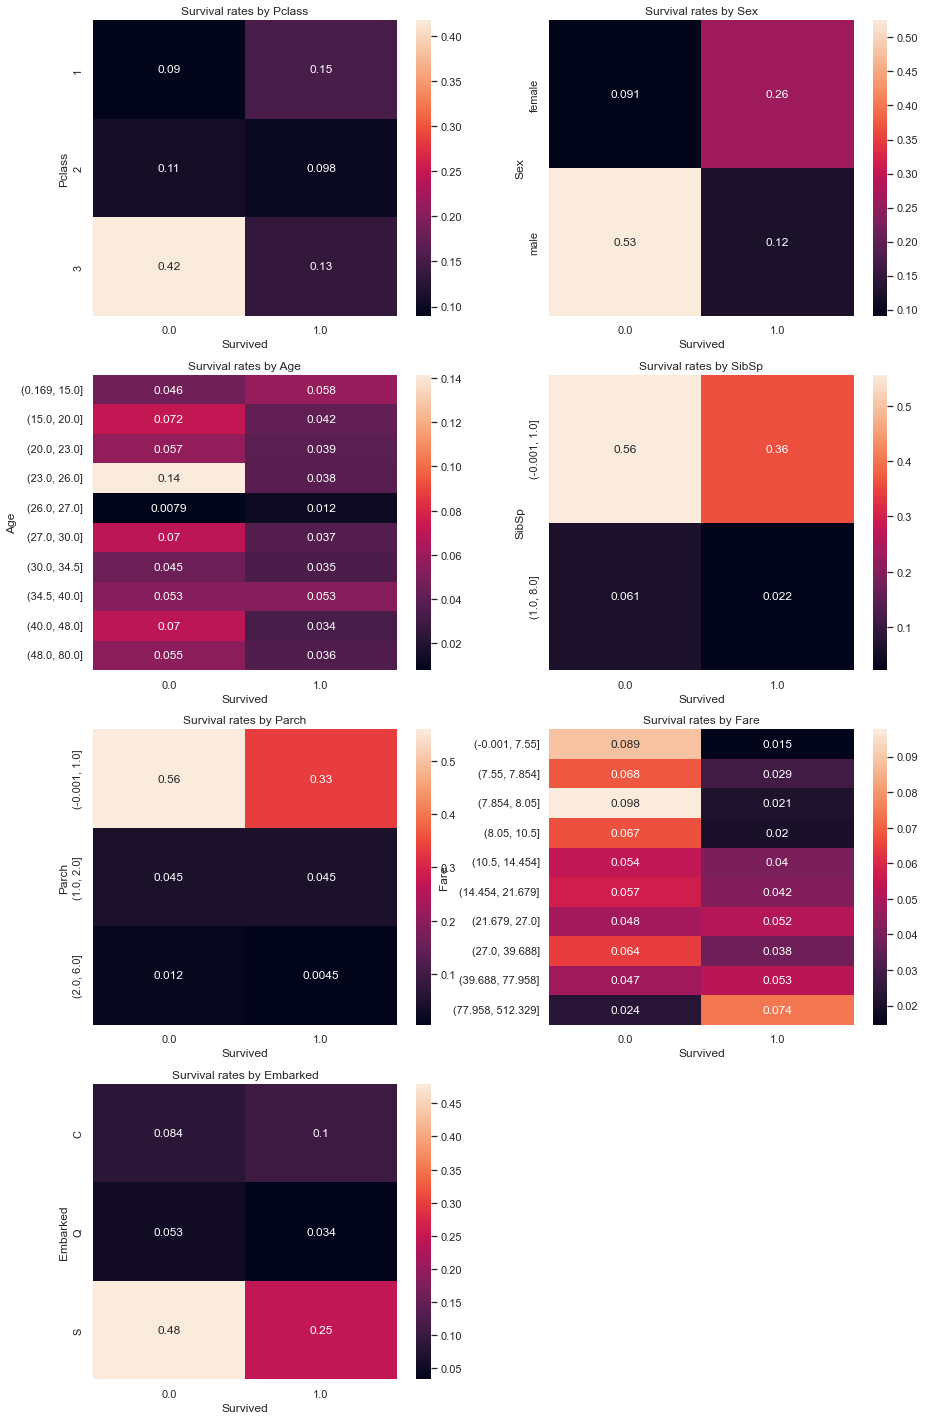

In [15]:
# loop over the lists and create survival rate tables
fig, ax = plt.subplots(4,2,figsize=(15,25)) # setup figure size and axis
ax[3][1].remove() #remove last empty slot
for index, axis in enumerate(fig.axes): #iterate over indices and axes
    axis.set_title(f'Survival rates by {features[index]}') # title to each table
    if numerical[index]: # if the feature is numerical
        # create a table with rates having the feature split into 10 quantiles and round result
        sns.heatmap(pd.crosstab(pd.qcut(combined_df.dropna()[features[index]], 10, duplicates='drop'), \
                                combined_df.Survived, normalize=True), ax=axis, annot=True)
    else: # if the feature is categorical
        # create a table with rates and round result
        sns.heatmap(pd.crosstab(combined_df.dropna()[features[index]], combined_df.Survived, \
                                normalize=True), ax=axis, annot=True)

### 2.4. Outliers <a name='outliers'></a>
Last step of our EDA is checking and deal with outliers, this is a very important step since outliers could affect our model's performance heavily.

#### 2.4.1. Box plots <a name='box'></a>
By scanning the previous survival rates heatmaps we could tell few features has outliers (ex: Fare, last quantile is covering more values than all other 9 quantiles together).

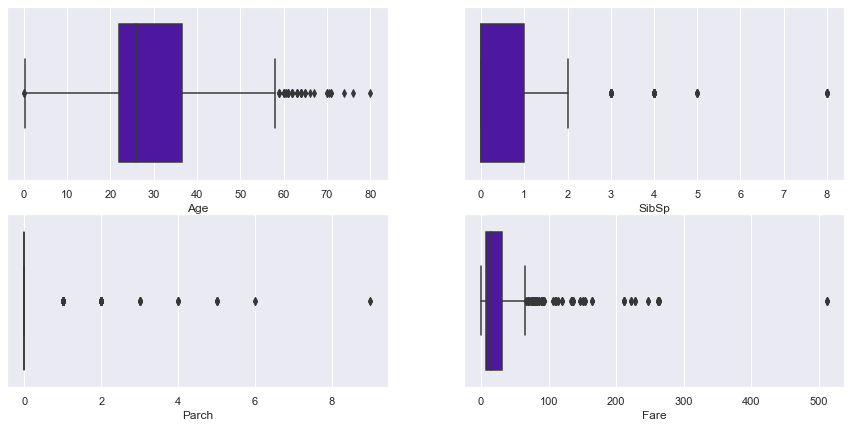

In [16]:
fig, ax = plt.subplots(2,2, figsize=(15,7)) # figure sizes and axis setup
numerical_features = ['Age','SibSp','Parch','Fare'] # list of numerical features
for index, axis in enumerate(fig.axes): # loop over axes
    sns.boxplot(x=combined_df[numerical_features[index]].dropna(), ax=axis) # boxplot each numerical feature

We notice few outliers so lets do some invistigations!
#### 2.4.2. Interquartile Range (IQR) <a name='iqr'></a>
Time to use IQR to detect outliers in the dataset.

In [17]:
outliers_indices = []
for feature in numerical_features: # loop over numerical features
    Q3 = np.quantile(combined_df[feature].dropna(), 0.75) # calculate 3rd quartile 
    Q1 = np.quantile(combined_df[feature].dropna(), 0.25) # calculate 1st quartile
    IQR = Q3 - Q1 # Calculate Interquartile Range
    # get the indices of identified outliers and append them to the list
    # Q3 + 1.5(IQR) < outlier or outlier < Q1 - 1.5(IQR)
    outliers_indices.extend(combined_df[(combined_df[feature].dropna() > (Q3 + (1.5 * IQR))) | \
                                       (combined_df[feature].dropna() < (Q1 - (1.5 * IQR)))].dropna().index)
outlier_indices_dict = Counter(outliers_indices) # creates a dict with the frequency of each index
# unpack the dict and flag the index as potential outlier if the freq is higher than 2
potential_outliers_indices = list(element for element, freq in outlier_indices_dict.items() if freq > 2)
# finally stopped pulling my hair after reading Yassine Ghouzam's notebook he also used the IQR method but
# the counter and unpack method is his (Or at least I found it there), full credit to him
# https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling#2.2-Outlier-detection
print(f'Found {len(potential_outliers_indices)} potential outliers!')

Found 13 potential outliers!


#### 2.4.3. Manual Checking <a name='manual'></a>
Now IQR method is really cool but we cant blindly trust it so we have to check the 'potential outliers' manually 1st then decide.

In [18]:
display(combined_df.loc[potential_outliers_indices].dropna().nlargest(len(potential_outliers_indices), feature)\
            .sort_values(feature, ascending=False))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,df_type,Prefix
438,0.0,1,"Fortune, Mr. Mark",male,64.0,1,4,263.00,S,train_df,Mr
27,0.0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,263.00,S,train_df,Mr
88,1.0,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,263.00,S,train_df,Miss
341,1.0,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,263.00,S,train_df,Miss
587,1.0,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,79.20,C,train_df,Mr
745,0.0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,71.00,S,train_df,Capt
159,0.0,3,"Sage, Master. Thomas Henry",male,14.5,8,2,69.55,S,train_df,Master
180,0.0,3,"Sage, Miss. Constance Gladys",female,28.0,8,2,69.55,S,train_df,Miss
201,0.0,3,"Sage, Mr. Frederick",male,28.0,8,2,69.55,S,train_df,Mr
324,0.0,3,"Sage, Mr. George John Jr",male,28.0,8,2,69.55,S,train_df,Mr


From manually checking the potential outliers we can conclude
- `Age`: Nothing seems suspicious aside from (Mr. Mark) which is also potentially outlier to `Fare` and `Parch` features.
- `SibSp`: The (Sage) is coming after our model and they have to be removed.
- `Parch`: Again (Mr.Mark) nothing else aside.
- `Fare`: Now its (Mr.Mark) and his family too

In [19]:
combined_df = combined_df.drop(potential_outliers_indices).reset_index(drop=True)

------------------
## 3. Feature Engineering <a name='eng'></a>
Now that our data is cleaned its time to do some feature engineering. A couple things were noticable from the inspection earlier.
* `Name` we can extract potentially useful information from the `Prefix` of the name.
* `SibSp` and `Parch` could be sum-ed up to 1 variable `Family`.
* `Pclass` needs to be converted into categorical variable

### Summary
1. **`Prefix` Feature**
   - Extracted `Prefix` from the title from the `Name` col.
   - Mapped `Prefix` into 4 categories (`Mr`,`Mrs`,`Master`,`Noble/Dr/Religion/Military`).
   - Answered some side quests about survival rates compared to women, children and rich people.


2. **`FamilySize` Feature**
   - Crafted `FamilySize` feature by adding `Parch` and `SibSp` and it turned out to have 10 categories.
   - Concluded the best surviving chance by familysize is a family of 3 members.
   - Mapped `FamilySize` into 4 categories:
     + `Alone` > 0 family members.
     + `Small` > 1 to 3 family members.
     + `Medium` > 4 to 5 family members.
     + `Big` > 6+ family members.
   - Dropped `Name`, `Parch` and `SibSp` cols.


3. **`Pclass`**
   - Converted dtype from int64 to str

Before starting with the feature engineering I defined a function to help highlight the visuals used in this section.

In [20]:
def highlight_x_bars(barplot, x):
    '''
    highlight_x_bars():
        This function takes in a barplot object and the number of columns to be highlighted then
        it outlines them in red.

    Args:
        barplot (obj): barplot object.
        x (int): number of bar(s) to highlight.
        
    Returns:
        None
    '''
    bar_heights = [patch.get_height() for patch in barplot.patches]
    for i in range(x):
        for patch in barplot.patches:
            if (patch.get_height() >= max(bar_heights)):
                patch.set_linewidth(4)
                patch.set_ls('--')
                patch.set_edgecolor('red')
                patch.set_zorder(3)
        bar_heights.remove(max(bar_heights))

### 2.1. `Prefix` feature from `Name` col <a name='prefix'></a>

In [21]:
# extracting the Prefix from the name column
combined_df.Prefix.value_counts()

Mr              751
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
the Countess      1
Jonkheer          1
Dona              1
Name: Prefix, dtype: int64

So we notice alot of patterns here:
1. There is alot of redundancy of some titles (Miss, Mrs, Mlle, Mme, Ms).
2. Some titles could be grouped into a single category (Col, Major, Capt, etc..).
3. Finally we get to answer our some of our side quest.

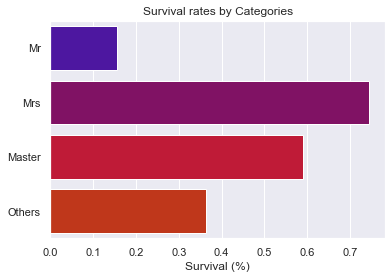

In [22]:
# creating a dict to map the prefixes into categories
# others = Noble/Dr/Religion/Military
Titles = {
        'Miss': 'Mrs',
        'Mlle': 'Mrs',
        'Ms': 'Mrs',
        'Mme': 'Mrs',
        'Col': 'Others',
        'Major': 'Others',
        'Capt': 'Others',
        'Lady': 'Others',
        'Sir': 'Others',
        'Don': 'Others',
        'the Countess': 'Others',
        'Jonkheer': 'Others',
        'Dona': 'Others',
        'Rev': 'Others',
        'Dr': 'Others'
        }

# replacing the prefixes
combined_df.Prefix.replace(Titles, inplace=True)

# plotting survival rates against titles
sns.barplot(data=combined_df, y='Prefix', x='Survived', ci=None)
plt.title('Survival rates by Categories')
plt.ylabel('')
plt.xlabel('Survival (%)')
plt.show()

Very well now we have categories sorted, time to answer some bonus quest questions!

#### Did women and children have priority? Yes
Hats off to the chivalrous men of the Titanic, May their souls rest in piece

#### Did the rich have higher chance of surviving? Yes
Seems like passengers of 1st class and highest Fare had the highest surviving chance

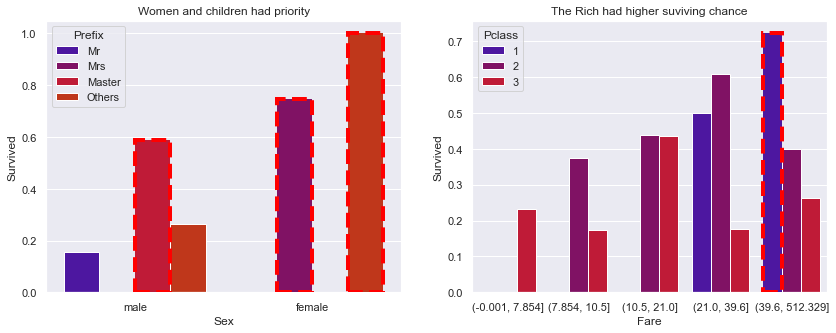

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# Plotting survival rates by Sex and Prefix
sns.barplot('Sex', 'Survived', data=combined_df, hue='Prefix', ci=None, ax=ax[0])
ax[0].set_title('Women and children had priority')
highlight_x_bars(ax[0], 3)

# Plotting Survival rates by Fare and Pclass
sns.barplot(pd.qcut(combined_df.Fare, 5, duplicates='drop'), 'Survived', data=combined_df, hue='Pclass', ci=None, ax=ax[1])
ax[1].set_title('The Rich had higher suviving chance')
highlight_x_bars(ax[1], 1)
plt.show()

### 2.2. `FamilySize` feature from `SibSp` & `Parch` Features <a name='family'></a>

`SibSp` and `Parch` are correlated as observed earlier and logically they can be added together to form `FamilySize` so thats what will happen
- `0`  > Lone traveller
- `1+` > Family of that size

In [24]:
# Creating FamilySize col where
combined_df['FamilySize'] = combined_df.Parch + combined_df.SibSp

# drop the old Name, Parch and SibSp cols
combined_df.drop(['Name', 'Parch', 'SibSp'], inplace=True, axis=1)
combined_df.FamilySize.value_counts()

0     790
1     235
2     157
3      43
4      22
5      21
6      16
7       8
10      4
Name: FamilySize, dtype: int64

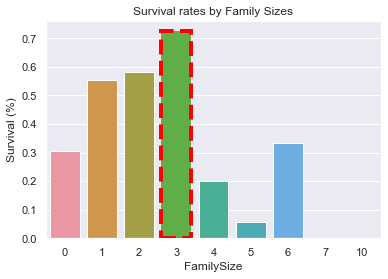

In [25]:
# plotting survival rates against Family number
bars = sns.barplot(data=combined_df, x='FamilySize', y='Survived', ci=None)

# highlight the highest chance
highlight_x_bars(bars, 1)
    
# bars.patches[3].set_color('red') #highlight highest bar
plt.title('Survival rates by Family Sizes')
plt.ylabel('Survival (%)')
plt.show()

#### What were the chances of families Surviving? Looks like a family of 3 members had the best odds
However, 10 values is still too much for a categorical variable. Hence, we will map reduce them to:
- `Alone` > 0 Family members
- `Small` > 1 to 3 Family members
- `Medium` > 4 to 5 Family members
- `Big` > 6+ Family members

In [26]:
# map numerical values into the new categories
categories = {0: 'Alone',
              range(1, 4): 'Small',
              range(4, 6): 'Medium',
              range(6, 11): 'Big'}

combined_df.FamilySize.replace(categories, inplace=True)

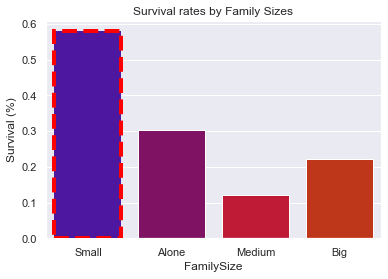

In [27]:
# plotting survival rates against Family number
bars = sns.barplot(data=combined_df, x='FamilySize', y='Survived', ci=None)
highlight_x_bars(bars, 1)
plt.title('Survival rates by Family Sizes')
plt.ylabel('Survival (%)')
plt.show()

### 2.3. `Pclass` feature <a name='pclass'></a>
This one is straight forward, converting `Pclass` into categorical variable ('str/obj' instead of 'int')

In [28]:
# converting into category
combined_df.Pclass = combined_df.Pclass.astype('str')

------------
## 4. Preprocessing <a name='pre'></a>
Now its time to prepare the data before moving it to the modeling step. To take care of the data we will:
1. Normalizing
2. Splitting
3. Encoding
4. Scaling

### Summary
- **Normalizing**
  1. Checked the numerical features `Age` and `Fare` distributions from earlier
  2. `Age` feature was normally distributed
  3. `Fare` feature was skewed and didnt have a normal distribution so I decided to normalize it using log normalization which turned out decent


- **Splitting**
  + Splitted the combined dataframe back into 2 dataframes (Labeled, unlabeled)
    1. Training data -> driven from the labeled data and split into **X_train**, **y_train**
    2. Testing data -> also driven from the labeled data and split into **X_test**, **y_test** (**30% of the training data**)
    3. Target data -> driven from the non labeled data -> **target_X** (the target to predict)


- **Transforming**
  + Defined a function to apply the transformations to keep the code DRY
  + Created 2 transformer objects (**OneHotEncoder**, **StandardScaler**)
  + Transformed the features of the 3 dataframes (**X_train**, **X_test**, **target_X**)

### 4.1. Normalizing <a name='normal'></a>
As noticed earlier some features didnt have normal distribution which could miss up the model performance (ex: `Fare`) hence we will normalize such features

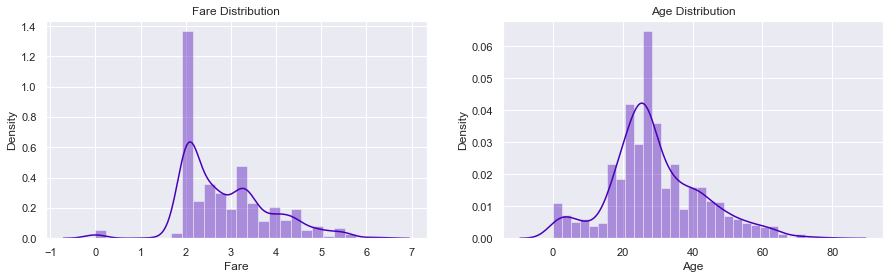

In [29]:
# normalizing fare feature using log function
combined_df.Fare = combined_df.Fare.apply(lambda x: np.log(x) if x > 0 else 0)

# checking fare and age distributions
fig, ax = plt.subplots(1, 2, figsize=(15,4))

sns.distplot(combined_df.Fare, ax=ax[0])
ax[0].set_title('Fare Distribution')

sns.distplot(combined_df.Age, ax=ax[1])
ax[1].set_title('Age Distribution')

plt.show()

Great the distributions seem closer to a normal distribution
### 4.2. Splitting <a name='split'></a>
Generally the data needs split into 3 portions
1. `Training` data -> driven from the labeled data and split into X_train, y_train
2. `Testing` data -> also driven from the labeled data and split into X_test, y_test
3. `Evaluating` data -> driven from the non labeled data (the target to predict)

In [30]:
# separating the labeled data from the unlabeled
labeled_df = combined_df[combined_df.df_type == 'train_df'].drop('df_type', axis=1)
unlabeled_df = combined_df[combined_df.df_type == 'eval_df'].drop('df_type', axis=1)

# creating vectors
X = labeled_df.drop('Survived', axis=1)
y = labeled_df.Survived
target_X = unlabeled_df.drop('Survived', axis=1)

# splitting labeled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10, stratify=y)

### 4.3. Transforming <a name='transform'></a>
Time to transform the features using:
- **Encoder** for the categorical features (**OneHotEncoder**).
- **Scaler** for the numerical features (**StandardScaler**).

In [31]:
# defining a general function for transforming the data
def transform_features(dfs, cols, transformer_obj):
    '''
    transform_features():
        This function takes in a list of dataframes with a list of column names and an
        object of a transformer (ex: scaler) THAT IS ALREADY TRAINED then apply the transformer
        to every dataframe in the list and returns another list that can be unpacked into dataframes.

    Args:
        dfs (list): list of DataFrames.
        cols (list): list of str.
        transformer_obj (obj): trained object of a transformer
        
    Returns:
        list: new_dfs
            list of dataframes with the feature transformations applied
    '''
    new_dfs = []
    for df in dfs:
        new_features = pd.DataFrame(data=transformer_obj.transform(df[cols]), \
                                        columns=transformer_obj.get_feature_names_out())
        df.drop(columns=cols, axis=1, inplace=True)
        df = pd.concat([df.reset_index(drop=True), new_features], axis=1)
        new_dfs.append(df)
    return new_dfs

Using that function all that is left is creating transformer objects and fit them to the training data then call the function to transform the dataframes

In [32]:
# first time using OneHotEncoder (always used get_dummies)
# Thanks to https://pythonsimplified.com/difference-between-onehotencoder-and-get_dummies/
# creating transformer objects
scaler = StandardScaler() 
ohe = OneHotEncoder(sparse=False) # (sparse=False to return np array)

# separating feature names by type
numerical_cols = ['Age', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Prefix', 'FamilySize']

# fitting the transformers to training data
scaler.fit(X_train[numerical_cols]) 
ohe.fit(X_train[categorical_cols]) 

OneHotEncoder(sparse=False)

In [33]:
# creating list of dataframes
dfs = [X_train, X_test, target_X]

# transform the features
dfs = transform_features(dfs, numerical_cols, scaler)
dfs = transform_features(dfs, categorical_cols, ohe)

# updating the dataframes
X_train, X_test, target_X = dfs

# checking the values
X_train.sample(5)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Prefix_Master,Prefix_Mr,Prefix_Mrs,Prefix_Others,FamilySize_Alone,FamilySize_Big,FamilySize_Medium,FamilySize_Small
568,-0.235822,0.371677,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
428,1.311291,0.637882,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
429,-0.677854,-0.591821,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
154,-1.119887,-0.458459,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
29,-0.309494,-0.140441,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


----------
## 5. Modeling <a name='model'></a>
With clean data its time to create the model objects and start feeding the data into them. but some testing is required first to settle on which model/combination of models to use. so to kick things off I decided to start with a baseline evaluation of each model performance then potentially look into tuning.

### Summary
1. **Model baseline Evaluation**
   - Started things by creating a list of model names and objects then setup stratified KFolds for the cross validation.
   - Created a dataframe to store the results.
   - Evaluated each model's cross validation performance (Accuracy (%) +/- Error (%)).
   - Average accuracy across all classifiers means = **81.35% +/- 3.33%**.
   - Adaboosting and RF had noticeably lower error margin despite having no tuning at all.
   
   
2. **Model Tuning**
   - Defined 3 functions to help with tuning the models and plotting the learning curve / feature importance.
   - Average accuracy across all classifiers means = **82.829% +/- 2.94%**.
   - Managed to tune all models to increase all the model's accuracy while preventing overfitting.
   - GradientBoosting, XGBoost and RF are the top performers.


   
| Model | Pre Tuning Mean Accuracy (%) | Pre Tuning Mean Error (%) | Post Tuning Mean Accuracy (%) | Post Tuning Mean Error (%) |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| LogisticRegression | 82.32% | 3.45% | 82.661% | 3.214% |
| KNeighborsClassifier | 81.64% | 3.9% | 82.325% | 4.239% |
| SVC | 81.98% | 3.21% | 82.486% | 2.364% |
| RandomForestClassifier | 79.77% | 2.58% | 83.0% | 2.758% |
| AdaBoostClassifier | 80.95% | 2.42% | 81.473% | 3.449% |
| GradientBoostingClassifier | 81.98% | 4.68% | 84.187% | 2.11% |
| XGBClassifier | 80.79% | 3.06% | 83.675% | 2.48% |



3. **Ensemble Modeling**
   - Combined the tuned models using VotingClassifier.
   - Tuned the voting classfier using gridsearch to optimize all of its possible parameters.
   - Obtained overall final accuracy of **83.51% +/- 3.041%**

### 5.1. Model baseline Evaluation <a name='baseline'></a>
Testing alot of models without any tuning to get a baseline evaluation and see how they perform.

In [34]:
seed = 10 # for random state
index = 0 # for loop later

# create a list of the classifiers
clf_list = [
    LogisticRegression(random_state=seed),
    KNeighborsClassifier(),
    SVC(random_state=seed),
    RandomForestClassifier(random_state=seed),
    AdaBoostClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    XGBClassifier(random_state=seed, eval_metric='mlogloss')
]

# classifiers names
clf_names = list(x[:x.find('(')] for x in str(clf_list).strip('[]').split(', '))

# intializing CV params
kfold = StratifiedKFold(shuffle=True, random_state=seed) # using default 5 splits

# dataframe to store results
evaluations = pd.DataFrame(columns=['Classifier', 'Mean_Accuracy_perc', 'Mean_Error_perc', 'Fit_Time'])

# loop over classifiers
for clf in clf_list:
    # calculate cross validation accuracies
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
    cv_results = cross_validate(clf, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
    
    # assign values to the dataframe
    evaluations.loc[index,'Classifier'] = clf_names[index]
    evaluations.loc[index,'Mean_Accuracy_perc'] = cv_results['test_score'].mean() * 100
    evaluations.loc[index,'Mean_Error_perc'] = cv_results['test_score'].std() * 100
    evaluations.loc[index,'Fit_Time'] = cv_results['fit_time'].mean()
    
    # move index to next row
    index += 1
    
evaluations.sort_values('Mean_Accuracy_perc', ascending=False, inplace=True)
display(evaluations)

,Classifier,Mean_Accuracy_perc,Mean_Error_perc,Fit_Time
0,LogisticRegression,82.323627,3.451261,0.021366
5,GradientBoostingClassifier,81.98899,4.680173,0.103967
2,SVC,81.980298,3.211799,0.014185
1,KNeighborsClassifier,81.648559,3.904917,0.002603
4,AdaBoostClassifier,80.954657,2.420632,0.113764
6,XGBClassifier,80.792409,3.060301,0.181142
3,RandomForestClassifier,79.771114,2.587211,0.167347


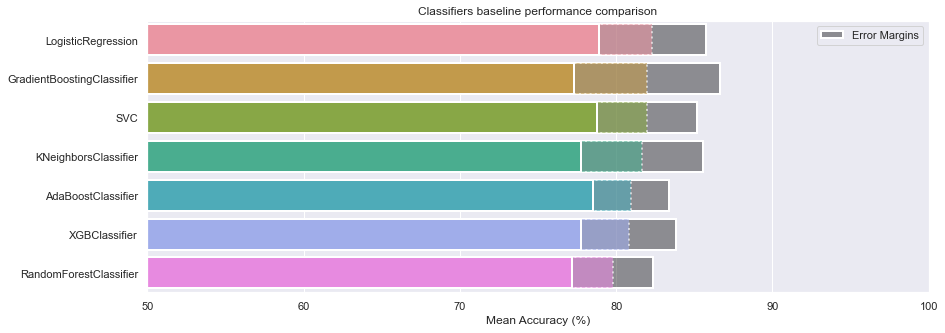

In [35]:
# Comparing baseline perfomance between models
fig, ax = plt.subplots(figsize=(14,5))

# calculate accuracy with error margins
acc_plus_err = evaluations['Mean_Accuracy_perc'] + evaluations['Mean_Error_perc']
acc_minus_err = evaluations['Mean_Accuracy_perc'] - evaluations['Mean_Error_perc']

# plotting bars
top_margin = sns.barplot(data=evaluations, x=acc_plus_err, y='Classifier', linewidth=2, \
                         color='purple', facecolor=(0, 0, 0, 0.4), label='Error Margins')
accuracy = sns.barplot(data=evaluations, x='Mean_Accuracy_perc', y='Classifier', \
                       linewidth=2, linestyle=':', edgecolor="#fff", alpha=0.6)
bot_margin = sns.barplot(data=evaluations, x=acc_minus_err, y='Classifier', linewidth=2)

# graph settings
plt.legend()
plt.xlim(50, 100)
plt.title('Classifiers baseline performance comparison')
ax.set_xlabel('Mean Accuracy (%)')
ax.set_ylabel('')
plt.show()

Average accuracy across all classifiers means = **81.35% +/- 3.33%**. However, the key thing to notice here is Adaboosting and RandomForest without any tuning had the least mean error (%) which indicates they would have great potential with some tuning.

### 5.2. Model Tuning <a name='tuning'></a>
Optimizing the parameters of each classifier and plotting the learning curve to check Bias and Variance.

In [58]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    '''
    plot_learning_curve():
        This function Generate Learning Curve plot.

    Args:
        estimator (obj): Model object.
        title (str): title of the plot.
        X (np.array): Unlabeled Data set.
        y (np.array): Labels.
        axes (obj): axes object.
        cv (int/cross-validation generator): Determines the cross-validation splitting strategy.
        n_jobs (int/None): Number of jobs to run in parallel.
        train_sizes (array): Numbers of training examples that will be used to generate the learning curve.
        
    Returns:
        plot object: plt
            learning curve plot object.
    '''
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(15, 5))

    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    return plt


def plot_feature_importance(estimator, X, y, axes=None):
    '''
    plot_learning_curve():
        This function Generate Learning Curve plot.

    Args:
        estimator (obj): Model object.
        X (np.array): Unlabeled Data set.
        y (np.array): Labels.
        axes (obj): axes object.
        
    Returns:
        plot object: plt
            feature importance plot object.
    '''
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(11, 5))

    axes.set_title(f'{str(estimator).split("(")[0]} Feature Importance Graph')

    # Plot feature importance
    axes.grid()
    feat_importances = pd.Series(estimator.fit(X,y).feature_importances_, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh', ax=axes)
    
    return plt


def grid_params_tuning(estimator, grid_params, scoring=None, n_jobs=None, cv=None, verbose=None):
    '''
    grid_params_tuning():
        Simple function to present gridsearch results.

    Args:
        estimator (obj): Model object.
        grid_params (dict): parameters to use for gridsearch.
        scoring (str): scoring metric to use.
        n_jobs (int/None): Number of jobs to run in parallel.
        cv (int/cross-validation generator): Determines the cross-validation splitting strategy.
        verbose (int/bool): verbosity level.
        
    Returns:
        model object: 
            tuned model object.
    '''
    title = str(estimator).split("(")[0] 

    # Printing the results
    print('='*120)
    print(f'> {title} Tuning')
    print('-'*120)
    
    # trying different parameters and fitting it to the data
    grid_cv = GridSearchCV(estimator, grid_params, scoring=scoring, n_jobs=n_jobs, cv=cv, verbose=verbose)
    grid_cv.fit(X_train, y_train)
    tuned_model = grid_cv.best_estimator_

    print('\n',':'*10,'Best Model',':'*10)
    print(f'Fit time = {round((grid_cv.refit_time_), 3)}')
    print(f'Accuracy = {(grid_cv.best_score_ *100).round(3)}%')
    print(f'Error Margin = {(grid_cv.cv_results_["std_test_score"][grid_cv.best_index_]*100).round(3)}%')
    print(f'Parameters = {grid_cv.best_params_}')
    
    # plot learning curve / feature importance
    if (estimator in clf_list[3:]): 
        fig, ax = plt.subplots(1,2, figsize=(15,5))
        plot_feature_importance(tuned_model, X_train, y_train, axes=ax[0])
        plot_learning_curve(tuned_model, title + ' Learning Curve', X_train, y_train, cv=kfold, axes=ax[1])
    else:
        plot_learning_curve(tuned_model, title + ' Learning Curve', X_train, y_train, cv=kfold)
    
    plt.show()
    # return tuned model
    return tuned_model

> LogisticRegression Tuning
------------------------------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 96 candidates, totalling 480 fits

 :::::::::: Best Model ::::::::::
Fit time = 0.012
Accuracy = 82.661%
Error Margin = 3.214%
Parameters = {'C': 0.6, 'penalty': 'l2', 'solver': 'newton-cg'}


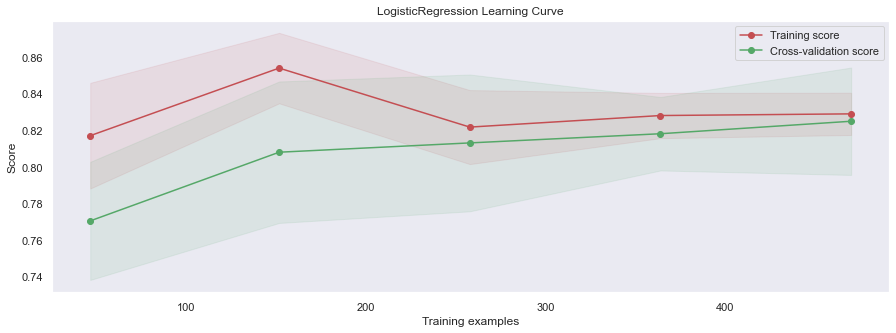

> KNeighborsClassifier Tuning
------------------------------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 16 candidates, totalling 80 fits

 :::::::::: Best Model ::::::::::
Fit time = 0.001
Accuracy = 82.325%
Error Margin = 4.239%
Parameters = {'algorithm': 'auto', 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}


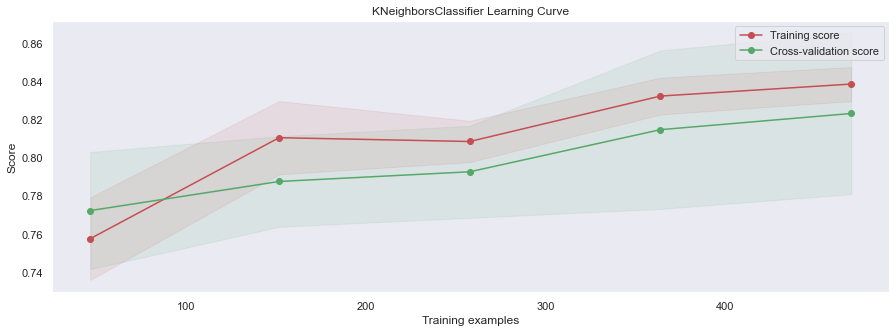

> SVC Tuning
------------------------------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits

 :::::::::: Best Model ::::::::::
Fit time = 0.043
Accuracy = 82.486%
Error Margin = 2.364%
Parameters = {'C': 2, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'probability': True, 'shrinking': True}


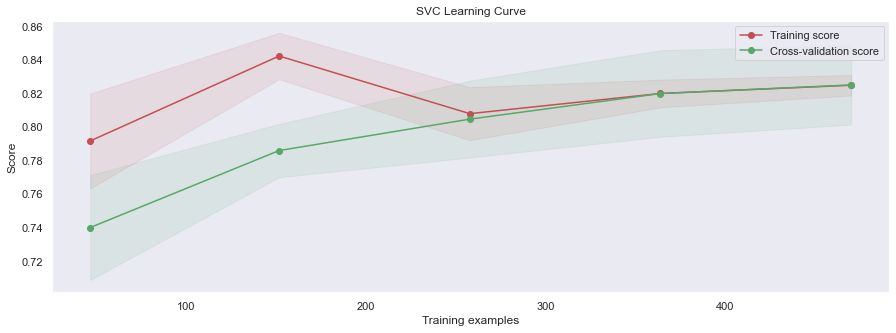

> RandomForestClassifier Tuning
------------------------------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 :::::::::: Best Model ::::::::::
Fit time = 0.415
Accuracy = 83.0%
Error Margin = 2.758%
Parameters = {'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 400}


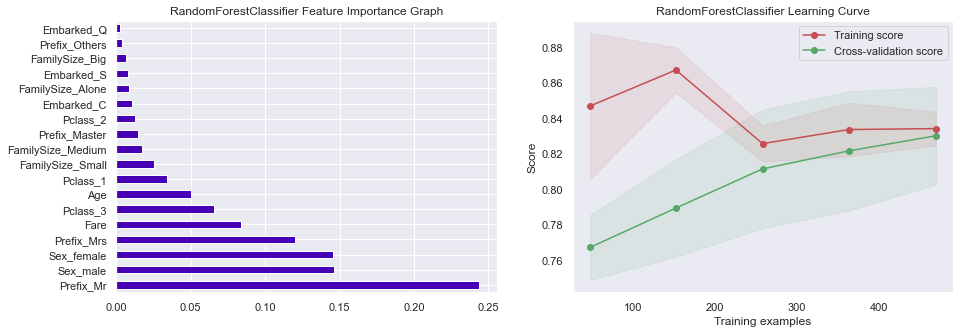

> AdaBoostClassifier Tuning
------------------------------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 40 candidates, totalling 200 fits

 :::::::::: Best Model ::::::::::
Fit time = 0.605
Accuracy = 81.473%
Error Margin = 3.449%
Parameters = {'algorithm': 'SAMME.R', 'learning_rate': 0.03, 'n_estimators': 500}


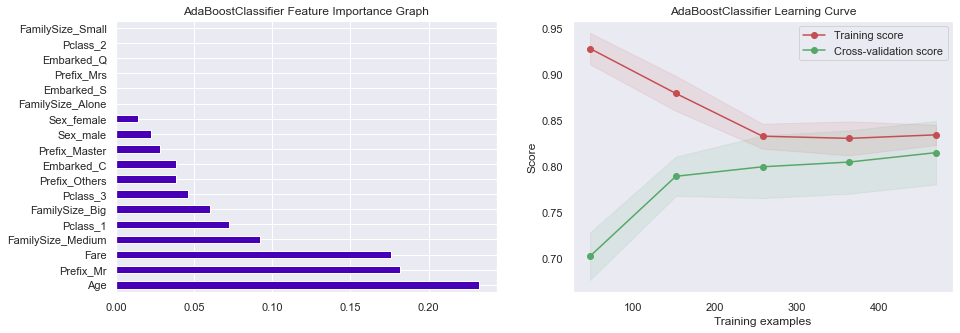

> GradientBoostingClassifier Tuning
------------------------------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 :::::::::: Best Model ::::::::::
Fit time = 0.298
Accuracy = 84.187%
Error Margin = 2.11%
Parameters = {'learning_rate': 0.1, 'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 10, 'n_estimators': 600}


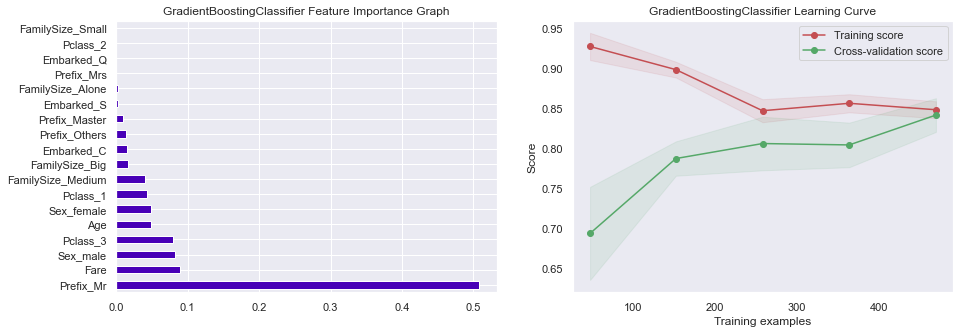

> XGBClassifier Tuning
------------------------------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 :::::::::: Best Model ::::::::::
Fit time = 0.078
Accuracy = 83.675%
Error Margin = 2.48%
Parameters = {'booster': 'gbtree', 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 0.01, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 1}


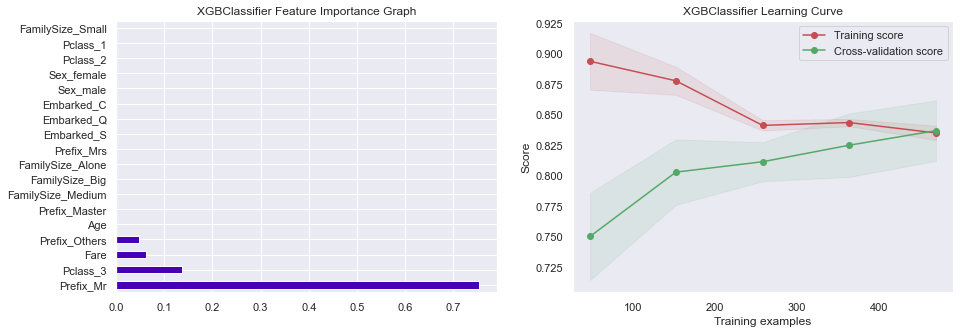

In [67]:
# list of parameters to test for each classifier
grid_params = [
    # Log Reg
    {'penalty': ['none', 'l1', 'l2', 'elasticnet'],
     'C': [0.001,0.01,0.1,0.3,0.6,1,2,3],
     'solver': ['newton-cg', 'lbfgs', 'liblinear']},
    
    # KNN
    {'n_neighbors': [6,9,12,17], 
     'weights': ['uniform', 'distance'],
     'algorithm': ['auto'],
     'p':[1,2]},
    
    # SVC
    {'kernel': ['poly'],
     'gamma': ['auto'],
     'degree': [2,3,4],
     'C': [1, 2, 3, 4, 5],
     'shrinking': [True, False],
     'probability': [True]},
    
    # RF
    {'max_depth': [4],
    'max_leaf_nodes': [10],
    'min_samples_leaf': [1,2],
    'min_samples_split': [12,13,14],
    'max_features': ['log2'],
    'n_estimators': [200,400]},
    
    # AdaBoost
    {'n_estimators': [400,500,600],
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [0.001,0.01,0.03,0.1]},
    
    # GradientBoosting
    {'n_estimators': [600],
    'learning_rate': [0.01,0.1],
    'min_samples_leaf': [9,10],
    'max_leaf_nodes': [2,3],
    'max_depth': [2,3,4]},
    
    # XGBoost
    {'n_estimators': [100],
     'learning_rate': [0.001,0.01],
     'booster': ['gbtree'],
     'max_depth': [2,3,4], 
     'reg_alpha': [0.01,0.1],
     'min_child_weight':[0.01],
     'reg_lambda': [1]}
]

# clf_names -> list of classifiers names
# clf_list -> list of classifiers
clf_tuned_list = []

# looping over the classifiers
for clf, index in zip(clf_list, range(len(clf_list))):
    # tuning each model's parameters
    tuned_model = grid_params_tuning(clf, grid_params[index],\
                                     scoring='accuracy', n_jobs=-1, cv=kfold, verbose=True)
    
    # adding the tuned model object to a list
    clf_tuned_list.append(tuned_model)

### 5.3. Ensemble Model <a name='voting'></a>
Now its time to combine all the tuned models using a soft voting classifier.

> VotingClassifier Tuning
------------------------------------------------------------------------------------------------------------------------
Fitting 5 folds for each of 234 candidates, totalling 1170 fits

 :::::::::: Best Model ::::::::::
Fit time = 0.989
Accuracy = 83.51%
Error Margin = 3.041%
Parameters = {'voting': 'hard', 'weights': [1, 2, 1, 1, 1, 2, 1]}


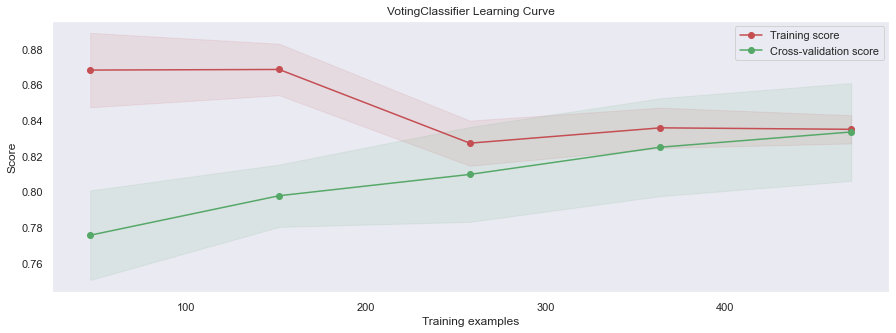

In [60]:
# Preparing a list of tuples for the voting classifier
models_list = list(zip(clf_names[:7],clf_tuned_list))
vc = VotingClassifier(estimators=models_list, verbose=True, n_jobs=-1)

# all possible parameters
grid_params_vc = {
    'voting': ['soft', 'hard'],
    'weights': [
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 2],
        [1, 1, 1, 1, 1, 2, 1],
        [1, 1, 1, 1, 2, 1, 2],
        [1, 1, 1, 1, 2, 2, 2],
        [1, 1, 1, 2, 1, 1, 1],
        [1, 1, 1, 2, 1, 1, 2],
        [1, 1, 1, 2, 1, 2, 1],
        [1, 1, 1, 2, 1, 2, 2],
        [1, 1, 1, 2, 2, 1, 1],
        [1, 1, 1, 2, 2, 1, 2],
        [1, 1, 1, 2, 2, 2, 2],
        [1, 1, 2, 1, 1, 1, 1],
        [1, 1, 2, 1, 1, 1, 2],
        [1, 1, 2, 1, 1, 2, 1],
        [1, 1, 2, 1, 1, 2, 2],
        [1, 1, 2, 1, 2, 1, 1],
        [1, 1, 2, 1, 2, 1, 2],
        [1, 1, 2, 1, 2, 2, 2],
        [1, 1, 2, 2, 1, 1, 1],
        [1, 1, 2, 2, 1, 1, 2],
        [1, 1, 2, 2, 1, 2, 1],
        [1, 1, 2, 2, 1, 2, 2],
        [1, 1, 2, 2, 2, 1, 1],
        [1, 1, 2, 2, 2, 1, 2],
        [1, 1, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 1],
        [1, 2, 1, 1, 1, 1, 2],
        [1, 2, 1, 1, 1, 2, 1],
        [1, 2, 1, 1, 1, 2, 2],
        [1, 2, 1, 1, 2, 1, 1],
        [1, 2, 1, 1, 2, 1, 2],
        [1, 2, 1, 1, 2, 2, 2],
        [1, 2, 1, 2, 1, 1, 1],
        [1, 2, 1, 2, 1, 1, 2],
        [1, 2, 1, 2, 1, 2, 1],
        [1, 2, 1, 2, 1, 2, 2],
        [1, 2, 1, 2, 2, 1, 1],
        [1, 2, 1, 2, 2, 1, 2],
        [1, 2, 1, 2, 2, 2, 1],
        [1, 2, 1, 2, 2, 2, 2],
        [1, 2, 2, 1, 1, 1, 1],
        [1, 2, 2, 1, 1, 1, 2],
        [1, 2, 2, 1, 1, 2, 1],
        [1, 2, 2, 1, 1, 2, 2],
        [1, 2, 2, 1, 2, 1, 1],
        [1, 2, 2, 1, 2, 1, 2],
        [1, 2, 2, 1, 2, 2, 2],
        [1, 2, 2, 2, 1, 1, 1],
        [1, 2, 2, 2, 1, 1, 2],
        [1, 2, 2, 2, 1, 2, 1],
        [1, 2, 2, 2, 1, 2, 2],
        [1, 2, 2, 2, 2, 1, 1],
        [1, 2, 2, 2, 2, 1, 2],
        [1, 2, 2, 2, 2, 2, 1],
        [1, 2, 2, 2, 2, 2, 2],
    ]
}

# tuning the voting classifier
tuned_vc = grid_params_tuning(vc,grid_params_vc,scoring='accuracy', n_jobs=-1, cv=kfold, verbose=True)

In [62]:
# fitting to the data
tuned_vc.fit(X_train,y_train)

# making the prediction
predictions = pd.Series(tuned_vc.predict(target_X).astype('int64'), name='Survived')
results = pd.concat([eval_df_ids, predictions], axis=1)

# saving the results to csv file
results.to_csv("predictions_VotingClassifier.csv",index=False)